# VANI

## Configure notebook

In [1]:
%load_ext autoreload

### Fix system path

In [2]:
import os
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
sys.path.append(os.path.dirname(os.getcwd()))

/g/g92/izzet/projects/iopp/vani-analysis-tool/vani-venv/bin/python
3.7.2 (default, Feb 26 2019, 08:59:10) 
[GCC 4.9.3]
sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)


### Filter unnecesary warnings

In [3]:
# Filter unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Import libraries

In [4]:
from IPython.display import Image, display

## Design of VANI

### Overview

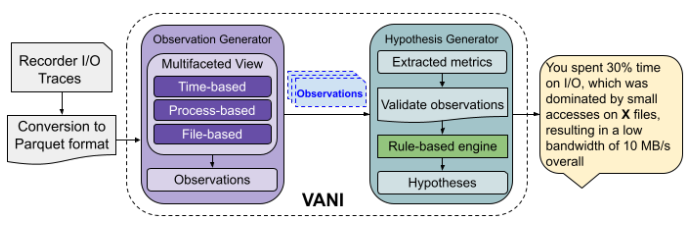

In [5]:
display(Image(filename="./figures/vani-design.png"))

- The VANI tool is created as a Python library that utilizes Dask
- To enable efficient distributed analysis, we first convert the collected I/O trace (from Recorder) into the Parquet format
- Then our tool consumes the Parquet files to build a multifaceted view of the workload
- Finally, we pass our observations through a rule engine which produces several hypotheses automatically

### Multifaceted View

To perform a multifaceted analysis, VANI consists of filter groups and metrics. We have five filter groups, that split the I/O trace into different scopes of the same performance data, as follows:

- Time-based: splits the I/O trace into time-steps according to the job time (**Today's demo**)
- Process-based: splits the I/O trace into processes for a given process (or app)
- File-based: splits the I/O trace into files for a given file (or directory)
- Transfer size-based: splits the I/O trace into transfer size groups (e.g., 4KB, 1MB)
- Bandwidth-based: splits the I/O trace into bandwidth groups (e.g., 100MB/s, 1GB/s)

On the other hand, the metrics are used to make observations and calculate the confidence score. We currently employ the following metrics: 

- Total I/O size
- I/O time per process 
- Number of I/O operations 
- Number of files
- Average bandwidth 
- Transfer size
- Parallelism

This multifaceted view of the traces grants to approach a potential bottleneck from different angles.

For instance, a time-step with densely concentrated I/O operations may be falsely identified as a bottleneck in the time-based view, but if the corresponding processes posses high parallelism in the process-based view with a satisfactory bandwidth, that observation gets discarded.

### Observation Generation

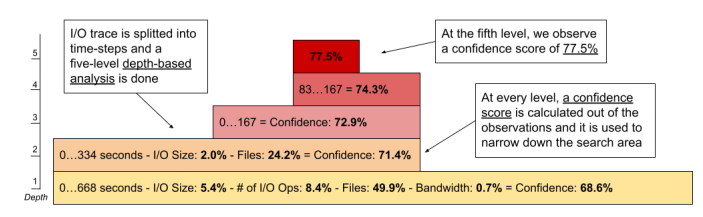

In [6]:
display(Image(filename="./figures/cm1-write-timeline.png"))

We score each metric by its observed value, in the filter group, based on global min-max of the metric. 

For instance, in a time-based filter group, if the average bandwidth of a particular time-step is significantly lower than the ideal bandwidth, we regard such bandwidth as an indicator of a bottleneck.

## Analysis of CM1

CM1 is an atmospheric simulation that models phenomena such as thunderstorms and tornadoes. It proceeds by iterations and produces more than 750 files (each around 128MB) during 193 simulation steps.

### Import libraries

In [7]:
from IPython.display import HTML
from vani.analyzer import Analyzer, ClusterOptions, ClusterType

### Initialize analyzer

In [8]:
%autoreload 2

# Initialize analyzer
co = ClusterOptions(cluster_type=ClusterType.Local)
vn = Analyzer(n_workers=8, cluster_options=co, debug=False)

distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-xg0k1lqu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-dmiuf9xe', purging
distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-k2qjbi7s', purging
distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-1wnk1_7a', purging
distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-atgm7y5a', purging
distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-7zyepych', purging
distributed.diskutils - INFO - Found stale lock file and directory '/tmp/izzet/vani-analysis-tool/dask-worker-space/worker-npsjk6vk', purging
distri

### Generate observations

In [9]:
%autoreload 2

# Log directory
log_dir = "/usr/workspace/iopp/vani_app_logs/cm1/nodes-32/workflow-4"

# Generate observations
observations = vn.analyze_parquet_logs(log_dir, max_depth=3, persist_stats=True, stats_file_prefix="cm1_")

Analysis completed: 100%|██████████| 3/3 [00:31<00:00, 10.58s/it]                    


### Render observation tree

In [10]:
%autoreload 2
observations.render()

Analysis
├── Time-based > Read
│   └── [0.000-778.504] Size=10 20.03125GB 94.6% | Time=1 0.00003s/p 0.0% | Ops=1 1282 4.7% | Files=10 2 0.1% | Bandwidth=1 1581.12929GB/s 2141.0% | Parallelism=10 1280 100.0% | Xfer=1 16.00000MB 100.0% | Confidence=48.6%
│       ├── [0.000-389.252] Size=1 0.53125GB 2.5% | Time=1 0.00015s/p 0.2% | Ops=1 34 0.1% | Files=10 2 0.1% | Bandwidth=1 1339.95094GB/s 1814.4% | Parallelism=10 32 2.5% | Xfer=1 16.00000MB 100.0% | Confidence=35.7%
│       │   ├── [0.000-194.626] Size=1 0.53125GB 2.5% | Time=1 0.00015s/p 0.2% | Ops=1 34 0.1% | Files=10 2 0.1% | Bandwidth=1 1339.95094GB/s 1814.4% | Parallelism=10 32 2.5% | Xfer=1 16.00000MB 100.0% | Confidence=35.7%
│       │   │   ├── [0.000-97.313] Size=1 0.53125GB 2.5% | Time=1 0.00015s/p 0.2% | Ops=1 34 0.1% | Files=10 2 0.1% | Bandwidth=1 1339.95094GB/s 1814.4% | Parallelism=10 32 2.5% | Xfer=1 16.00000MB 100.0% | Confidence=35.7%
│       └── [389.252-778.504] Size=10 19.50000GB 92.1% | Time=1 0.00003s/p 0.0% | Ops

### Generate hypotheses

In [11]:
%autoreload 2
observations.generate_hypotheses()

├── Within the scope of I/O write operations, there is a 68.6% possibility of an I/O bottleneck because the application spends a lot of time during I/O operations, accesses only 772 (49.9%) files, achieves a low bandwidth of 0.49590GB/s per process, does not have a lot of concurrent operations performed only by 1 (0.1%) ranks, and has a small transfer size of 0.50970MB
│   ├── During 97.313-194.626, we suspect an I/O bottleneck with a confidence of 74.3% because the application spends a lot of time during I/O operations, accesses only 124 (8.0%) files, achieves a low bandwidth of 0.43699GB/s per process, does not have a lot of concurrent operations performed only by 1 (0.1%) ranks, and has a small transfer size of 0.42103MB
│   ├── During 0.000-97.313, there is a 71.4% possibility of an I/O bottleneck because the application spends a lot of time during I/O operations, accesses only 102 (6.6%) files, achieves a low bandwidth of 0.50599GB/s per process, does not have a lot of concurrent 

### Generate flame graph

In [12]:
%autoreload 2
filter_group_node = observations.children[0]
vn.save_filter_group_node_as_flamegraph(filter_group_node=filter_group_node, output_path="flamegraph-cm1.txt")

In [13]:
! chmod +x flamegraph.pl
! flamegraph.pl flamegraph-cm1.txt > flamegraph-cm1.svg

In [14]:
HTML(filename="flamegraph-cm1.svg")